In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-13 09:09:28.609856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(iii) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-25(iii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.015625 +0.0234375j  0.0390625+0.0234375j  0.015625 +0.0078125j ...
 -0.0703125-0.015625j   0.03125  +0.0625j     0.03125  -0.0390625j]
2048
84336
(2048, 84336)
[0.02507629 0.01529848 0.00455177 ... 0.00481338 0.00519102 0.01487319]
0
(10000, 2048)
(10000,)
[ 0.0234375+0.j         0.0234375-0.015625j   0.0390625+0.0234375j ...
  0.0390625-0.0078125j -0.03125  -0.0234375j  0.0390625+0.03125j  ]
2048
82801
(2048, 82801)
[0.02520441 0.01502084 0.0049348  ... 0.00482676 0.00487362 0.01468235]
1
(20000, 2048)
(20000,)
[-0.015625 -0.015625j   0.046875 -0.1171875j -0.0078125-0.0234375j ...
  0.0234375-0.0234375j  0.       +0.0390625j  0.0390625-0.0546875j]
2048
93261
(2048, 93261)
[0.025306   0.01482049 0.00509501 ... 0.00460829 0.00502229 0.01480712]
2
(30000, 2048)
(30000,)
[-0.0078125-0.1953125j -0.0390625-0.0234375j  0.109375 +0.109375j  ...
  0.015625 -0.1640625j -0.0234375+0.1015625j  0.0546875-0.109375j ]
2048
80564
(2048, 80564)
[0.02515789 0.01462993 0.00543042 ... 0.00497138 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(iii) dataset 

In [5]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-13 09:39:14.475414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 5.4164 - accuracy: 0.1391
test loss, test acc: [5.416418075561523, 0.13911250233650208]


In [7]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[7 7 2 ... 5 2 2]
7
[[   2    0 5272    8   26 4607   69   16]
 [   1    0 5651   10   32 4021  280    5]
 [   0    0 5921   11   25 3871  167    5]
 [   1    0 4713   13   14 4944  297   18]
 [   0    0 5109    6   15 4787   69   14]
 [   1    0 4787    8   30 5039  122   13]
 [   1    0 5374   10   14 4502   83   16]
 [   0    0 4852    3    0 4834  255   56]]
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.59      0.23     10000
           3       0.19      0.00      0.00     10000
           4       0.10      0.00      0.00     10000
           5       0.14      0.50      0.22     10000
           6       0.06      0.01      0.01     10000
           7       0.39      0.01      0.01     10000

    accuracy                           0.14     80000
   macro avg       0.17      0.14   

Test Accuracy:0.1391125


Text(0.5, 1.0, 'Accuracy:0.139')

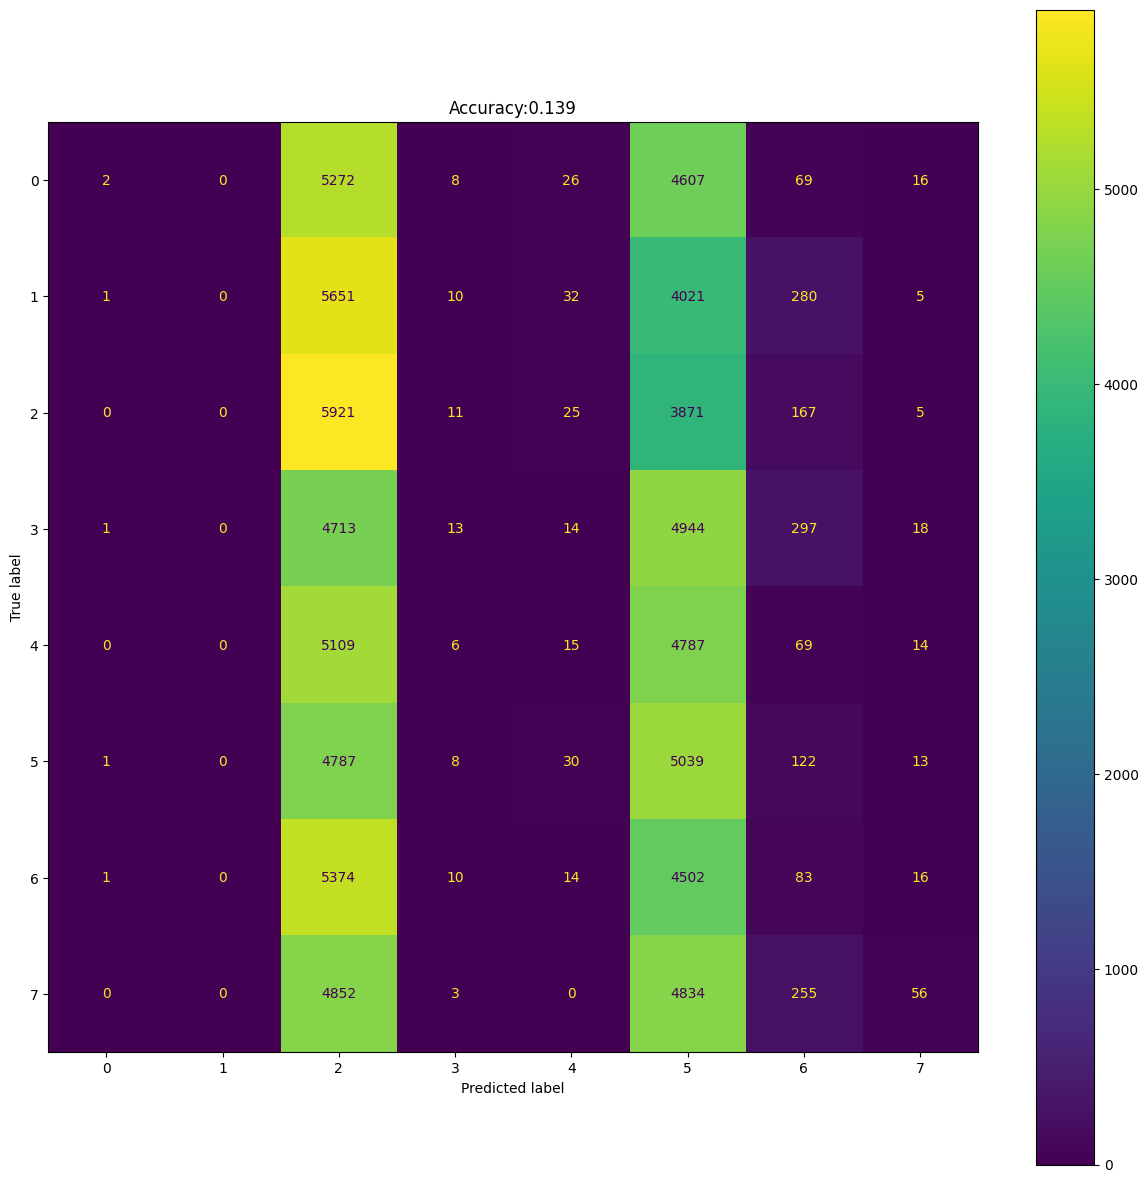

In [8]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(i) model to Nordic Device-25(iii) dataset 

In [9]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [10]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [11]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.7653 - accuracy: 0.1413
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2342 - accuracy: 0.1599
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0905 - accuracy: 0.1802
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0306 - accuracy: 0.2042
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9964 - accuracy: 0.2195
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9730 - accuracy: 0.2317
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9557 - accuracy: 0.2425
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9422 - accuracy: 0.2514
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9304 - accuracy: 0.2617
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 

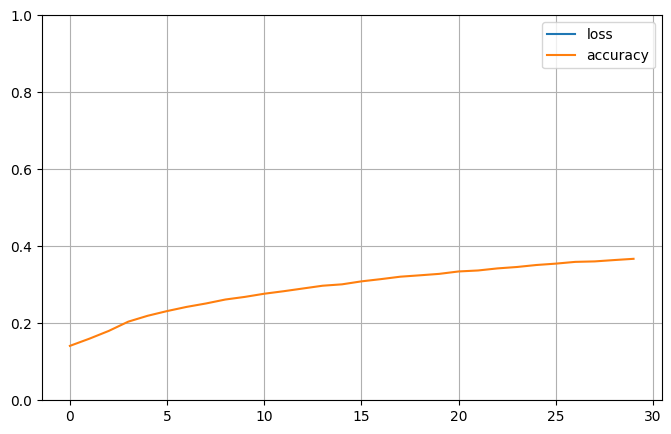

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [13]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7894 - accuracy: 0.3714
test loss, test acc: [1.7894304990768433, 0.3714124858379364]


In [14]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 7 7 ... 3 7 0]
7
[[4065  801  360 1589 1016  563  484 1122]
 [ 681 6276   89 1039  413   99  603  800]
 [1601 1458  953 2363 1101  631  649 1244]
 [1011  996  237 4974  651  420  498 1213]
 [2030  847  366 1691 2613  675  551 1227]
 [2147  764  431 2162 1528 1456  432 1080]
 [1661 1354  456 1660 1105  476 2095 1193]
 [ 765  600  184  515  379  146  130 7281]]
              precision    recall  f1-score   support

           0       0.29      0.41      0.34     10000
           1       0.48      0.63      0.54     10000
           2       0.31      0.10      0.15     10000
           3       0.31      0.50      0.38     10000
           4       0.30      0.26      0.28     10000
           5       0.33      0.15      0.20     10000
           6       0.38      0.21      0.27     10000
           7       0.48      0.73      0.58     10000

    accuracy                           0.37     80000
   macro avg       0.36      0.37  

Test Accuracy:0.3714125


Text(0.5, 1.0, 'Accuracy:0.371')

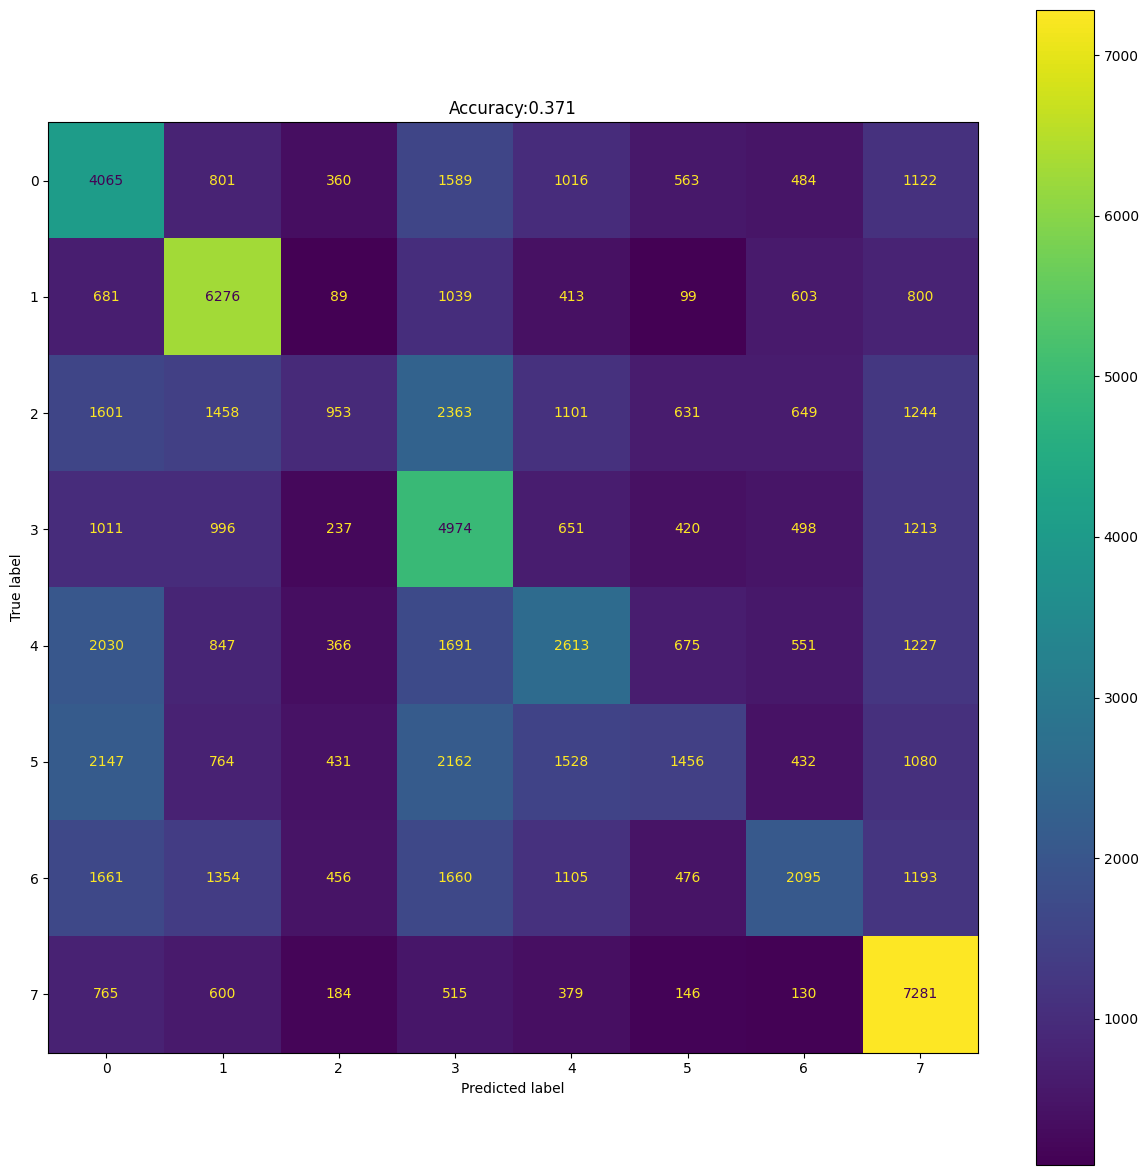

In [15]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(ii) model to Nordic Device-25(iii) dataset 

In [16]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [17]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.9368 - accuracy: 0.1388
test loss, test acc: [5.936782360076904, 0.13875000178813934]


In [18]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 5 6 ... 2 2 5]
0
[[  40    0 3847    0    3 5846  253   11]
 [  56    6 3491    0    5 5426  905  111]
 [  10    0 4070    0    0 4766 1143   11]
 [  67    4 4001    0    0 5101  798   29]
 [  10    0 3353    0    2 6465  165    5]
 [  29    1 3511    0    1 5896  554    8]
 [   4    0 3532    0    0 5380 1078    6]
 [  15    4 2588    0    0 6921  464    8]]
              precision    recall  f1-score   support

           0       0.17      0.00      0.01     10000
           1       0.40      0.00      0.00     10000
           2       0.14      0.41      0.21     10000
           3       0.00      0.00      0.00     10000
           4       0.18      0.00      0.00     10000
           5       0.13      0.59      0.21     10000
           6       0.20      0.11      0.14     10000
           7       0.04      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.16      0.14   

Test Accuracy:0.13875


Text(0.5, 1.0, 'Accuracy:0.139')

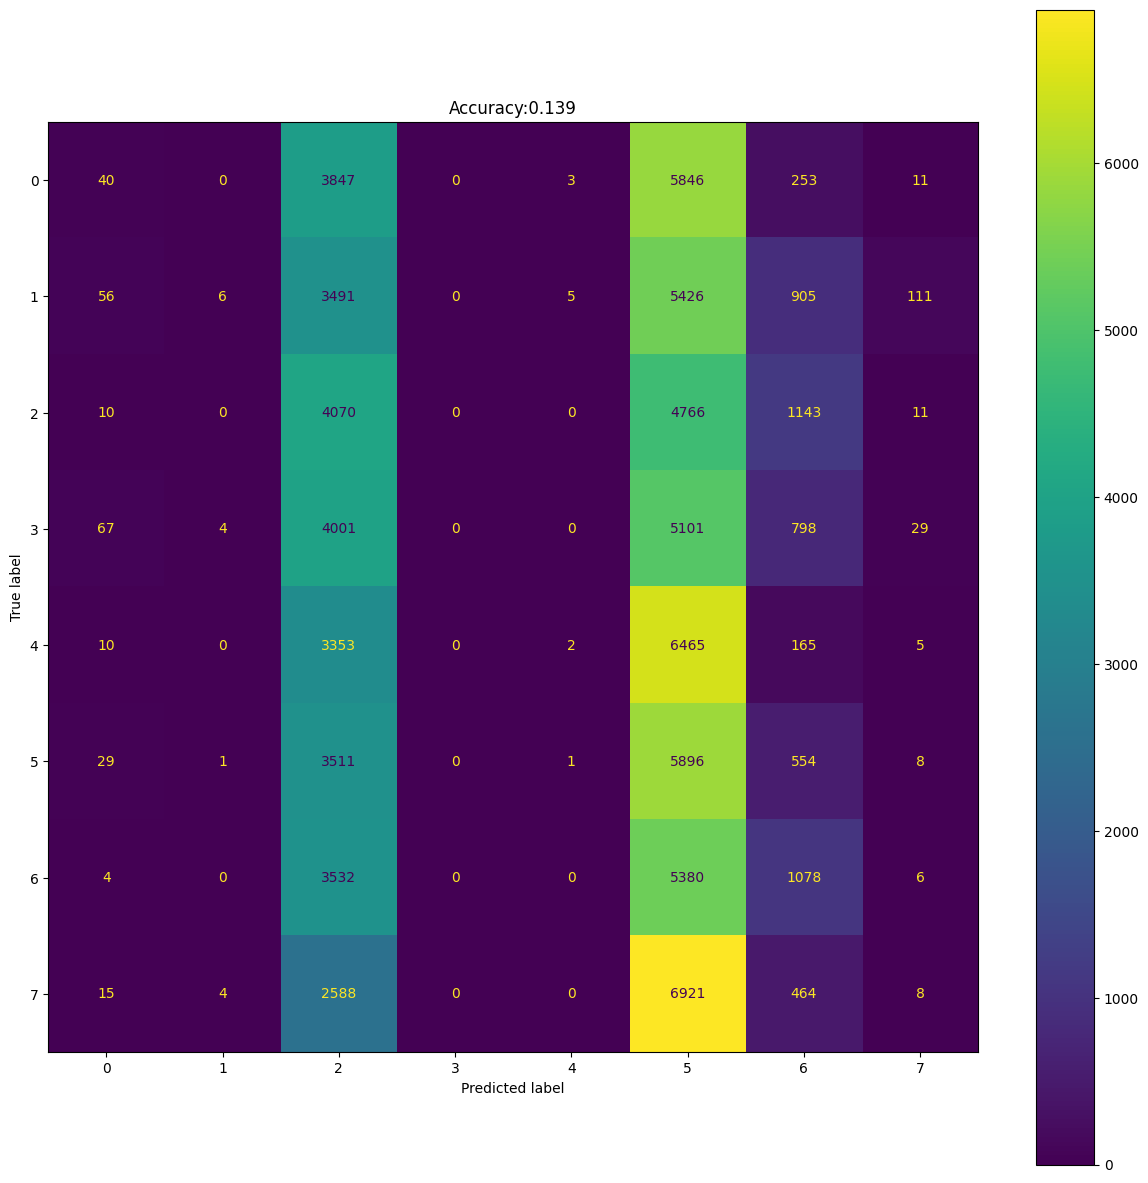

In [19]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(ii) model to Nordic Device-25(iii) dataset 

In [20]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [21]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [22]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.7552 - accuracy: 0.1621
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.1692 - accuracy: 0.1885
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0182 - accuracy: 0.2160
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9627 - accuracy: 0.2399
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9336 - accuracy: 0.2593
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9152 - accuracy: 0.2715
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9011 - accuracy: 0.2802
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8902 - accuracy: 0.2877
Epoch 9/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.8804 - accuracy: 0.2934
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

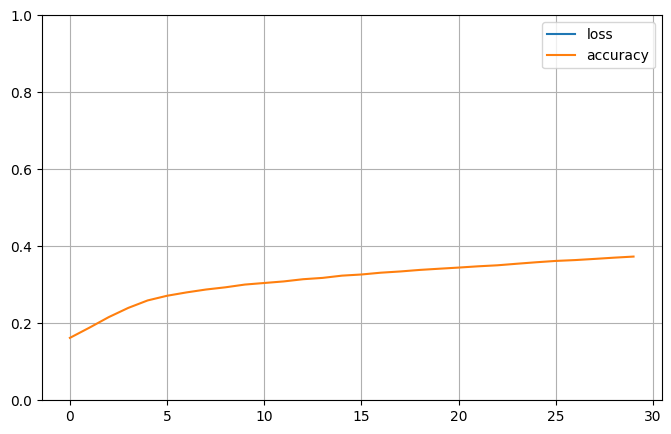

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [24]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7596 - accuracy: 0.3730
test loss, test acc: [1.7595572471618652, 0.3729749917984009]


In [25]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[1 1 1 ... 1 3 6]
1
[[1376 1194  728 1916 1261  402 1339 1784]
 [ 214 6133  457  811  366  112  956  951]
 [ 349 1232 2316 1500  572  310 2700 1021]
 [ 281  725  422 5988  435  181 1218  750]
 [ 810  755  689 1282 2737  561 1556 1610]
 [ 563  886  939 2300  949  792 2198 1373]
 [ 268  871  885 1501  604  233 4278 1360]
 [ 244  783  358  887  351  136 1023 6218]]
              precision    recall  f1-score   support

           0       0.34      0.14      0.20     10000
           1       0.49      0.61      0.54     10000
           2       0.34      0.23      0.28     10000
           3       0.37      0.60      0.46     10000
           4       0.38      0.27      0.32     10000
           5       0.29      0.08      0.12     10000
           6       0.28      0.43      0.34     10000
           7       0.41      0.62      0.50     10000

    accuracy                           0.37     80000
   macro avg       0.36      0.37   

Test Accuracy:0.372975


Text(0.5, 1.0, 'Accuracy:0.373')

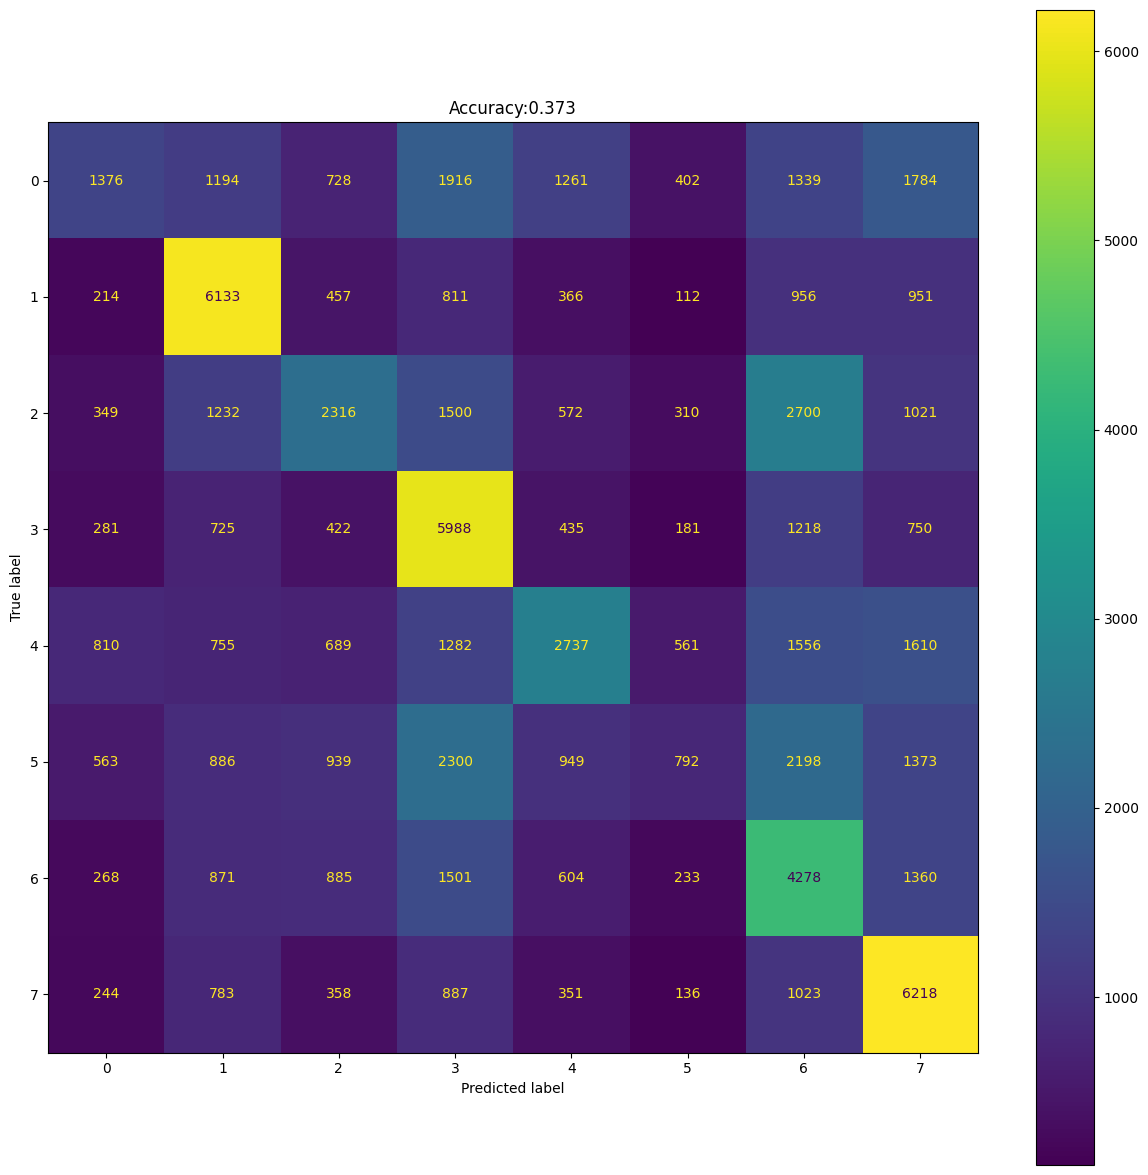

In [26]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-25(iii) dataset 

In [27]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [28]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.1174 - accuracy: 0.6878
test loss, test acc: [1.117380976676941, 0.6877999901771545]


In [29]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[3578    4   96   18 5104  962  189   49]
 [   1 9948   26    2    0    9    9    5]
 [ 475  147 5113  175  182 2106 1704   98]
 [  47    1   86 9247   63  467   76   13]
 [3364    9  392   48 2913 2211  914  149]
 [1305   13  592  114  676 5936 1096  268]
 [ 120  107  814   26   61  424 8441    7]
 [  22    0    6    3    7   80   34 9848]]
              precision    recall  f1-score   support

           0       0.40      0.36      0.38     10000
           1       0.97      0.99      0.98     10000
           2       0.72      0.51      0.60     10000
           3       0.96      0.92      0.94     10000
           4       0.32      0.29      0.31     10000
           5       0.49      0.59      0.53     10000
           6       0.68      0.84      0.75     10000
           7       0.94      0.98      0.96     10000

    accuracy                           0.69     80000
   macro avg       0.69      0.69  

Test Accuracy:0.6878


Text(0.5, 1.0, 'Accuracy:0.688')

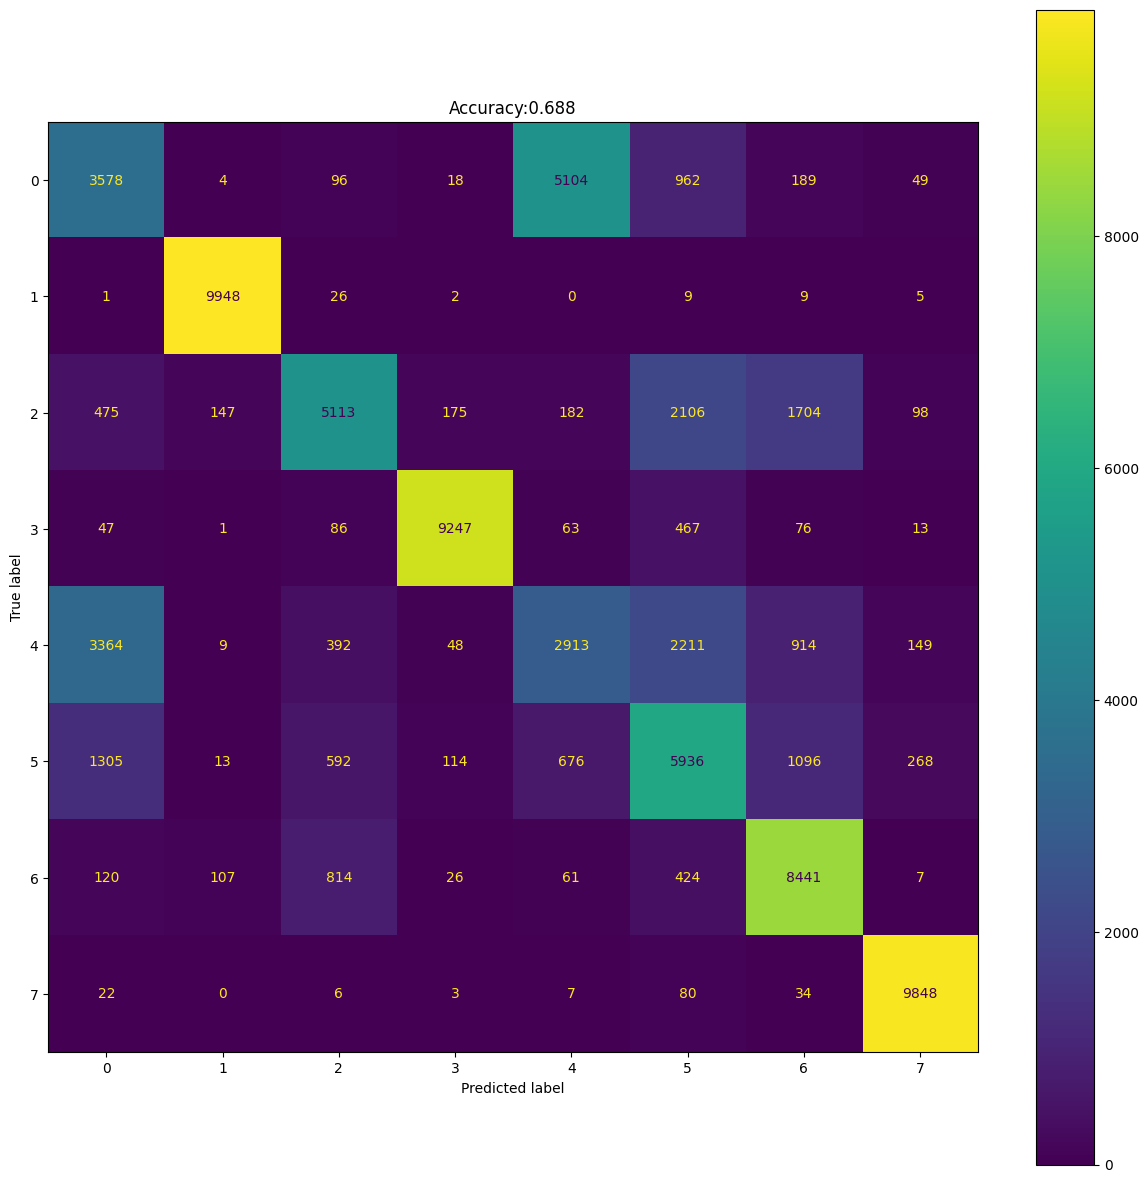

In [30]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [31]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [32]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [33]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.9085 - accuracy: 0.7072
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7007 - accuracy: 0.7346
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6212 - accuracy: 0.7558
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5909 - accuracy: 0.7689
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5766 - accuracy: 0.7741
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5682 - accuracy: 0.7773
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5632 - accuracy: 0.7797
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5597 - accuracy: 0.7816
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5569 - accuracy: 0.7819
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - los

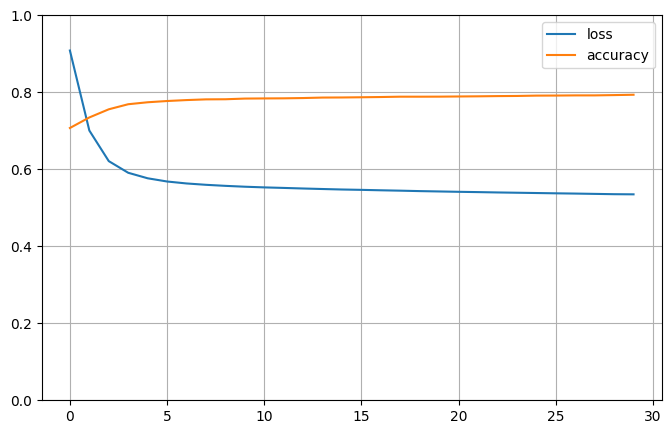

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [35]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5340 - accuracy: 0.7943
test loss, test acc: [0.5339875221252441, 0.7942875027656555]


In [36]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[7802    0  124   13 1536  491   32    2]
 [   2 9941   33    6    0    6   12    0]
 [  51   11 7135   62  434 1143 1159    5]
 [  17    0   34 9776   17  114   42    0]
 [3151    0  654   31 4141 1780  240    3]
 [ 532    0 1107   89 1416 6402  433   21]
 [  25    5  977   18  161  338 8472    4]
 [  10    0   12    5   17   72   10 9874]]
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     10000
           1       1.00      0.99      1.00     10000
           2       0.71      0.71      0.71     10000
           3       0.98      0.98      0.98     10000
           4       0.54      0.41      0.47     10000
           5       0.62      0.64      0.63     10000
           6       0.81      0.85      0.83     10000
           7       1.00      0.99      0.99     10000

    accuracy                           0.79     80000
   macro avg       0.79      0.79  

Test Accuracy:0.7942875


Text(0.5, 1.0, 'Accuracy:0.794')

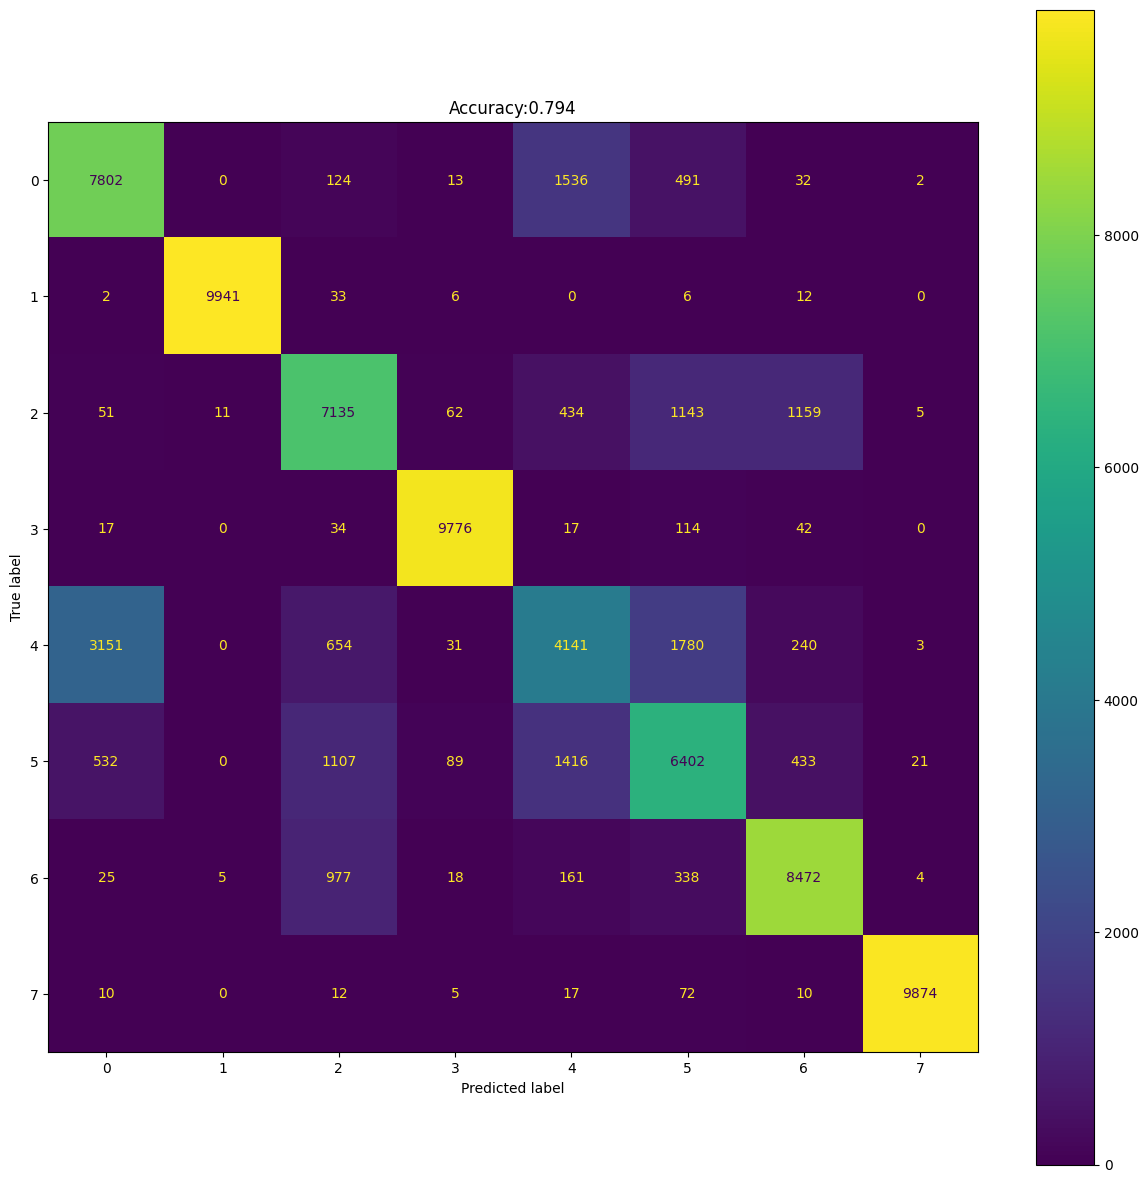

In [37]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-25(iii) dataset 

In [38]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [39]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.2491 - accuracy: 0.6728
test loss, test acc: [1.2491194009780884, 0.6728000044822693]


In [40]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[4 2 4 ... 0 7 4]
4
[[4739    0  319   19 4093  824    6    0]
 [   1 9958   16    4    4   17    0    0]
 [  75   41 7471   86  112 2004  196   15]
 [   3    1   32 9907    5   45    2    5]
 [ 833    9 2011  297 3094 3679   42   35]
 [ 230    6 1479  301  661 7253   36   34]
 [  14  263 6844   29   38  918 1883   11]
 [   5    6   12   75   63  320    0 9519]]
              precision    recall  f1-score   support

           0       0.80      0.47      0.60     10000
           1       0.97      1.00      0.98     10000
           2       0.41      0.75      0.53     10000
           3       0.92      0.99      0.96     10000
           4       0.38      0.31      0.34     10000
           5       0.48      0.73      0.58     10000
           6       0.87      0.19      0.31     10000
           7       0.99      0.95      0.97     10000

    accuracy                           0.67     80000
   macro avg       0.73      0.67   

Test Accuracy:0.6728


Text(0.5, 1.0, 'Accuracy:0.673')

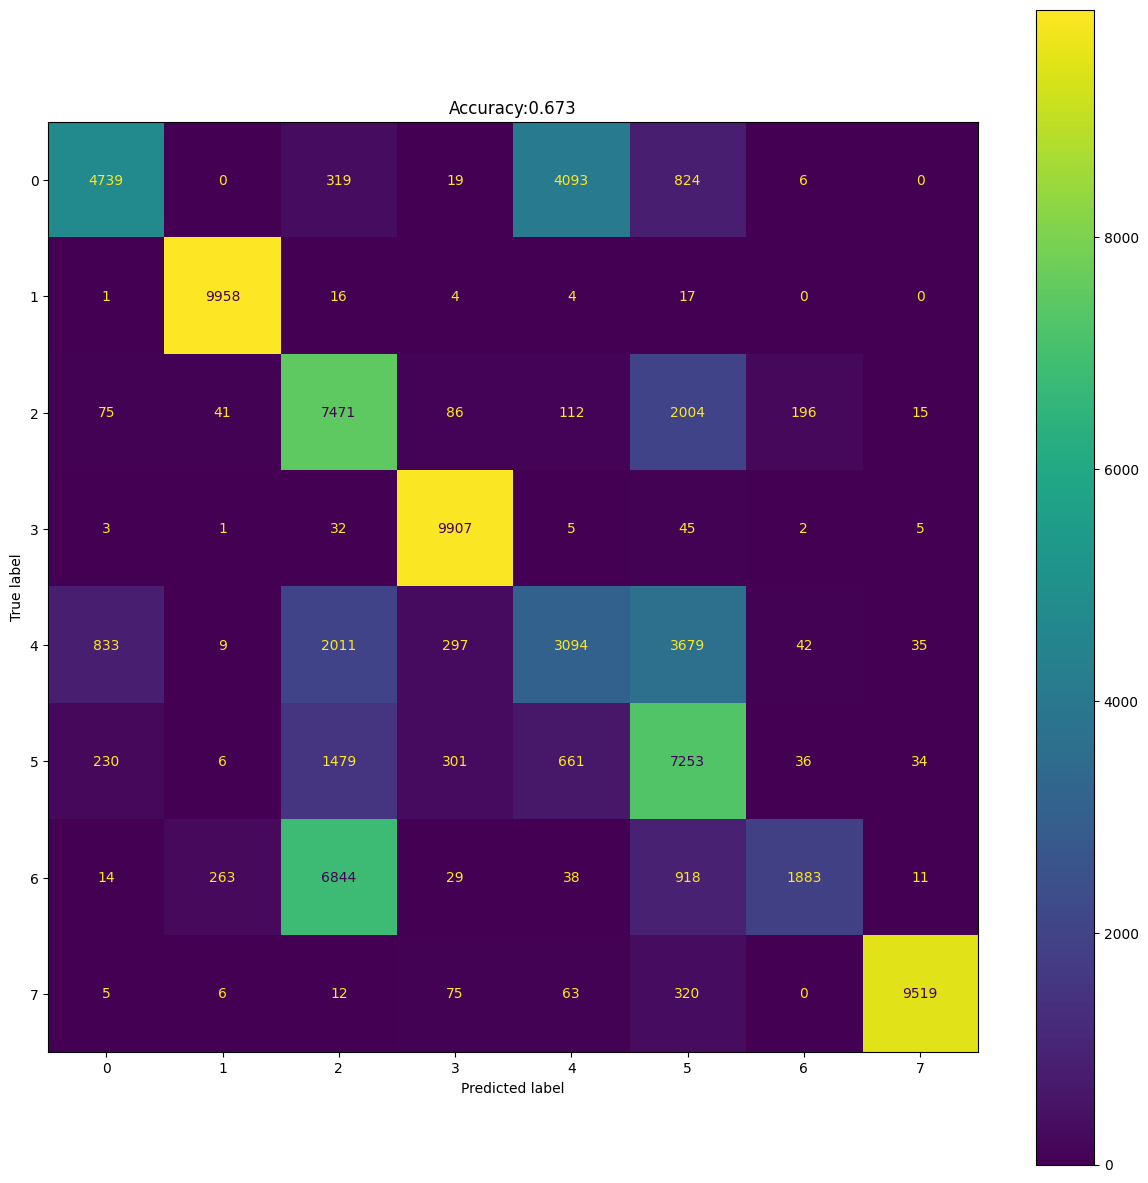

In [41]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-25(iii) dataset 

In [42]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [43]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.8211 - accuracy: 0.7308
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6848 - accuracy: 0.7505
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.6362 - accuracy: 0.7593
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6128 - accuracy: 0.7657
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6007 - accuracy: 0.7695
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5936 - accuracy: 0.7712
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5890 - accuracy: 0.7728
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5862 - accuracy: 0.7738
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5839 - accuracy: 0.7754
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

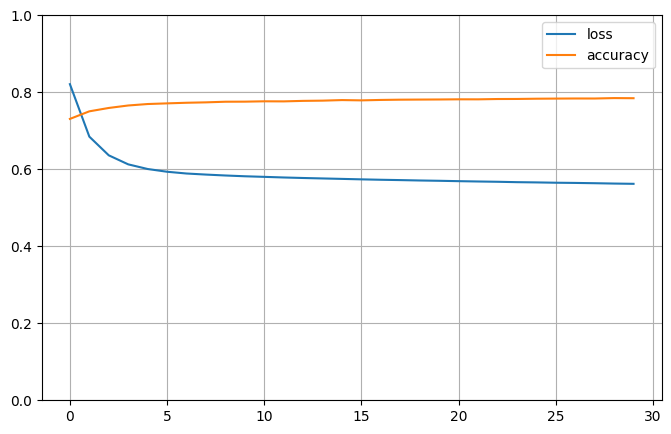

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [46]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5626 - accuracy: 0.7864
test loss, test acc: [0.5625978708267212, 0.7863500118255615]


In [47]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 2 4 ... 4 7 7]
4
[[8302    0  114    6 1113  442   22    1]
 [   1 9953   13    0    7   18    6    2]
 [  48    1 6023   22  761 1280 1856    9]
 [   3    0    5 9855   33   62   32   10]
 [1902    0 1097   60 4033 2470  397   41]
 [ 269    0  864   81 1762 6721  246   57]
 [   4    4 1336    3  134  319 8193    7]
 [   4    0    4   13   58   76   17 9828]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     10000
           1       1.00      1.00      1.00     10000
           2       0.64      0.60      0.62     10000
           3       0.98      0.99      0.98     10000
           4       0.51      0.40      0.45     10000
           5       0.59      0.67      0.63     10000
           6       0.76      0.82      0.79     10000
           7       0.99      0.98      0.99     10000

    accuracy                           0.79     80000
   macro avg       0.78      0.79  

Test Accuracy:0.78635


Text(0.5, 1.0, 'Accuracy:0.786')

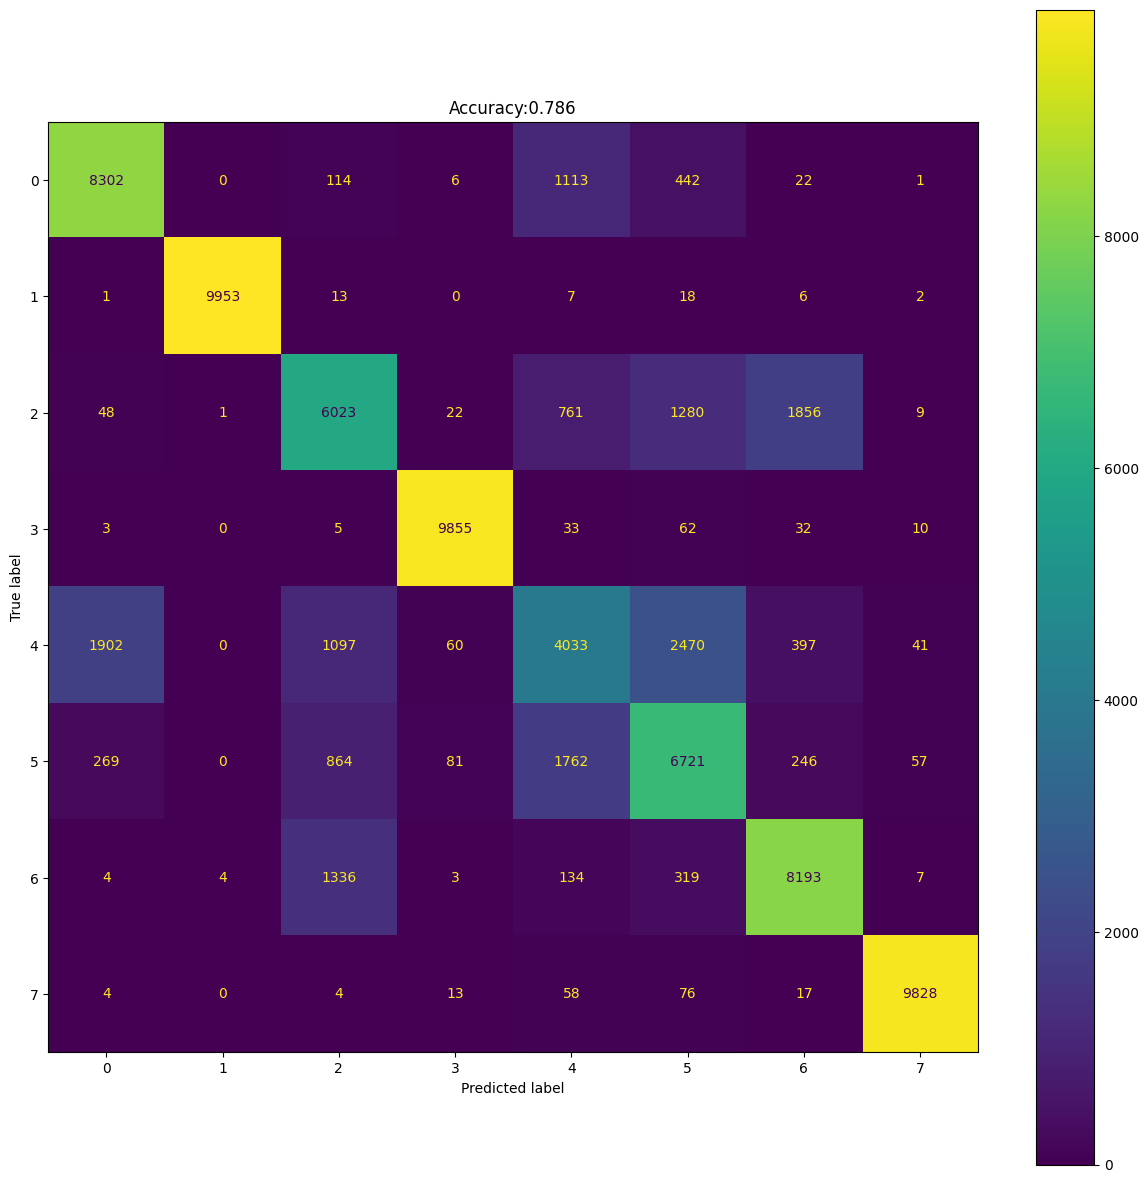

In [48]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(iii) dataset 

In [49]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [50]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 6.8548 - accuracy: 0.1210
test loss, test acc: [6.854795455932617, 0.12096250057220459]


In [51]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 1 5 ... 6 2 2]
3
[[   0    1 8393    4    0  812  789    1]
 [   0    1 9421   27    0  373  171    7]
 [   0    0 8516    4    0  656  823    1]
 [   0    0 7808    1    0  700 1489    2]
 [   0    0 8441    2    0  653  904    0]
 [   0    0 8329    1    0  671  999    0]
 [   0    1 9010   37    0  456  486   10]
 [   0    0 8287    2    0  469 1240    2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.33      0.00      0.00     10000
           2       0.12      0.85      0.22     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.14      0.07      0.09     10000
           6       0.07      0.05      0.06     10000
           7       0.09      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.10      0.12  

Test Accuracy:0.1209625


Text(0.5, 1.0, 'Accuracy:0.121')

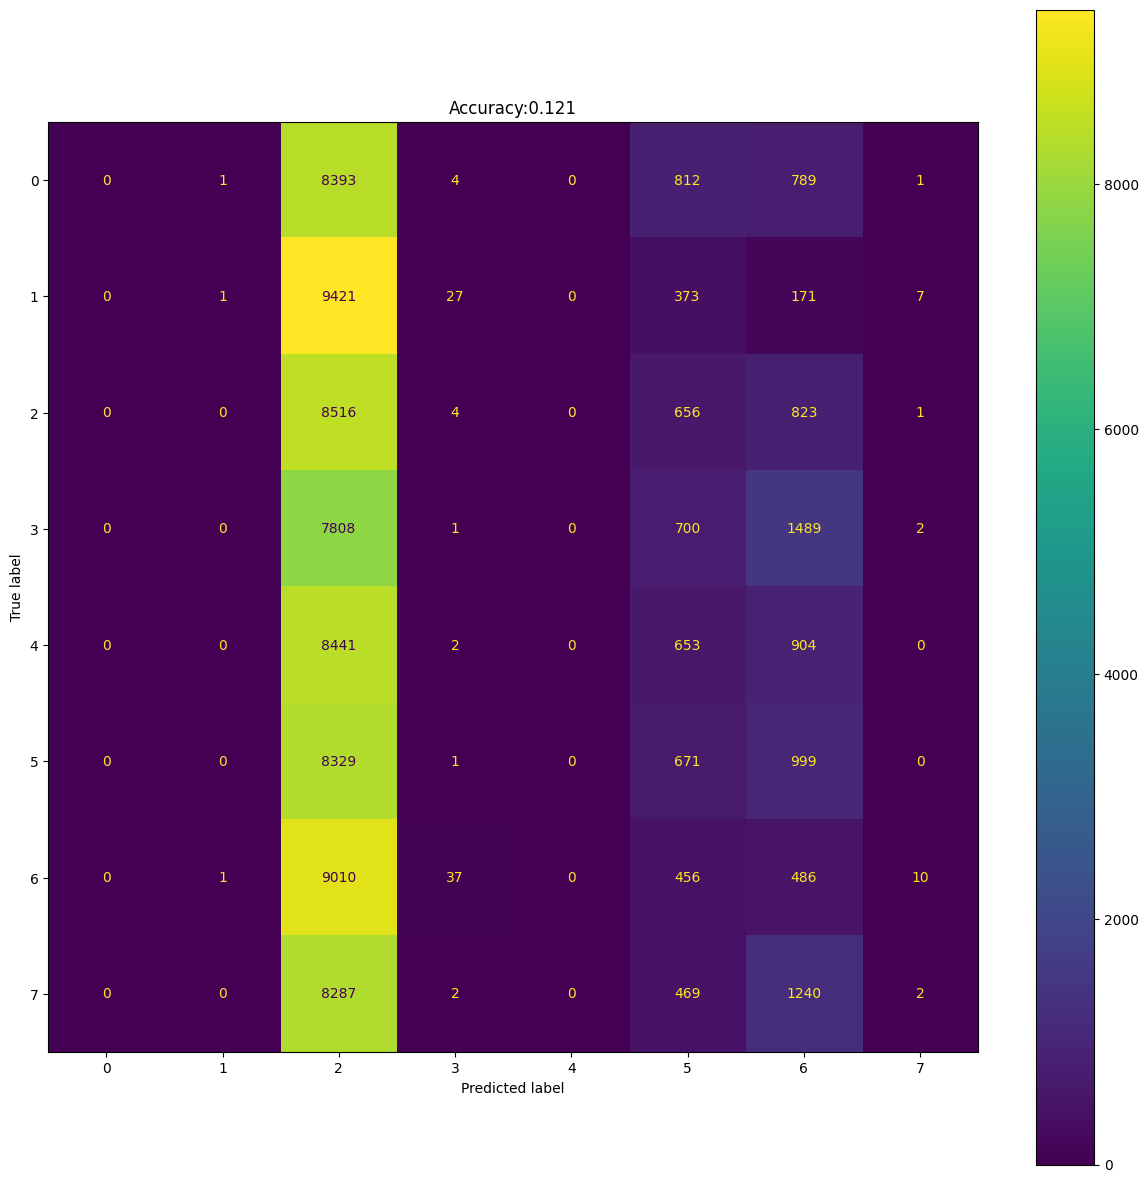

In [52]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [53]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [54]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [55]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6711 - accuracy: 0.1759
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.1100 - accuracy: 0.2147
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9488 - accuracy: 0.2386
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8871 - accuracy: 0.2611
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8524 - accuracy: 0.2804
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8283 - accuracy: 0.2997
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8083 - accuracy: 0.3127
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7910 - accuracy: 0.3253
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7760 - accuracy: 0.3348
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss: 

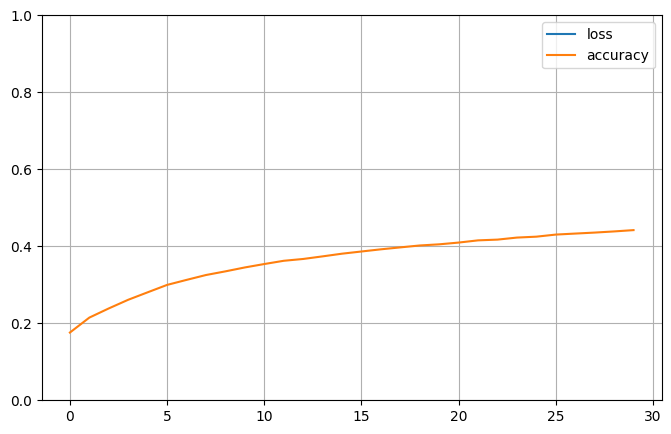

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [57]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 1.5897 - accuracy: 0.4436
test loss, test acc: [1.589722752571106, 0.44362500309944153]


In [58]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[6 6 6 ... 5 1 0]
6
[[1922  699 1000  911 3041  722  567 1138]
 [ 223 6476  490  347  779  119 1280  286]
 [ 489  940 2923 1091 1476  575 1740  766]
 [ 377  492  741 4951 1462  335  978  664]
 [ 624  524  640  798 5542  554  367  951]
 [ 768  493 1195 1170 3082 1542  578 1172]
 [ 145 1689 1096  725  523  140 5239  443]
 [ 197  290  326  510 1147  132  503 6895]]
              precision    recall  f1-score   support

           0       0.41      0.19      0.26     10000
           1       0.56      0.65      0.60     10000
           2       0.35      0.29      0.32     10000
           3       0.47      0.50      0.48     10000
           4       0.33      0.55      0.41     10000
           5       0.37      0.15      0.22     10000
           6       0.47      0.52      0.49     10000
           7       0.56      0.69      0.62     10000

    accuracy                           0.44     80000
   macro avg       0.44      0.44  

Test Accuracy:0.443625


Text(0.5, 1.0, 'Accuracy:0.444')

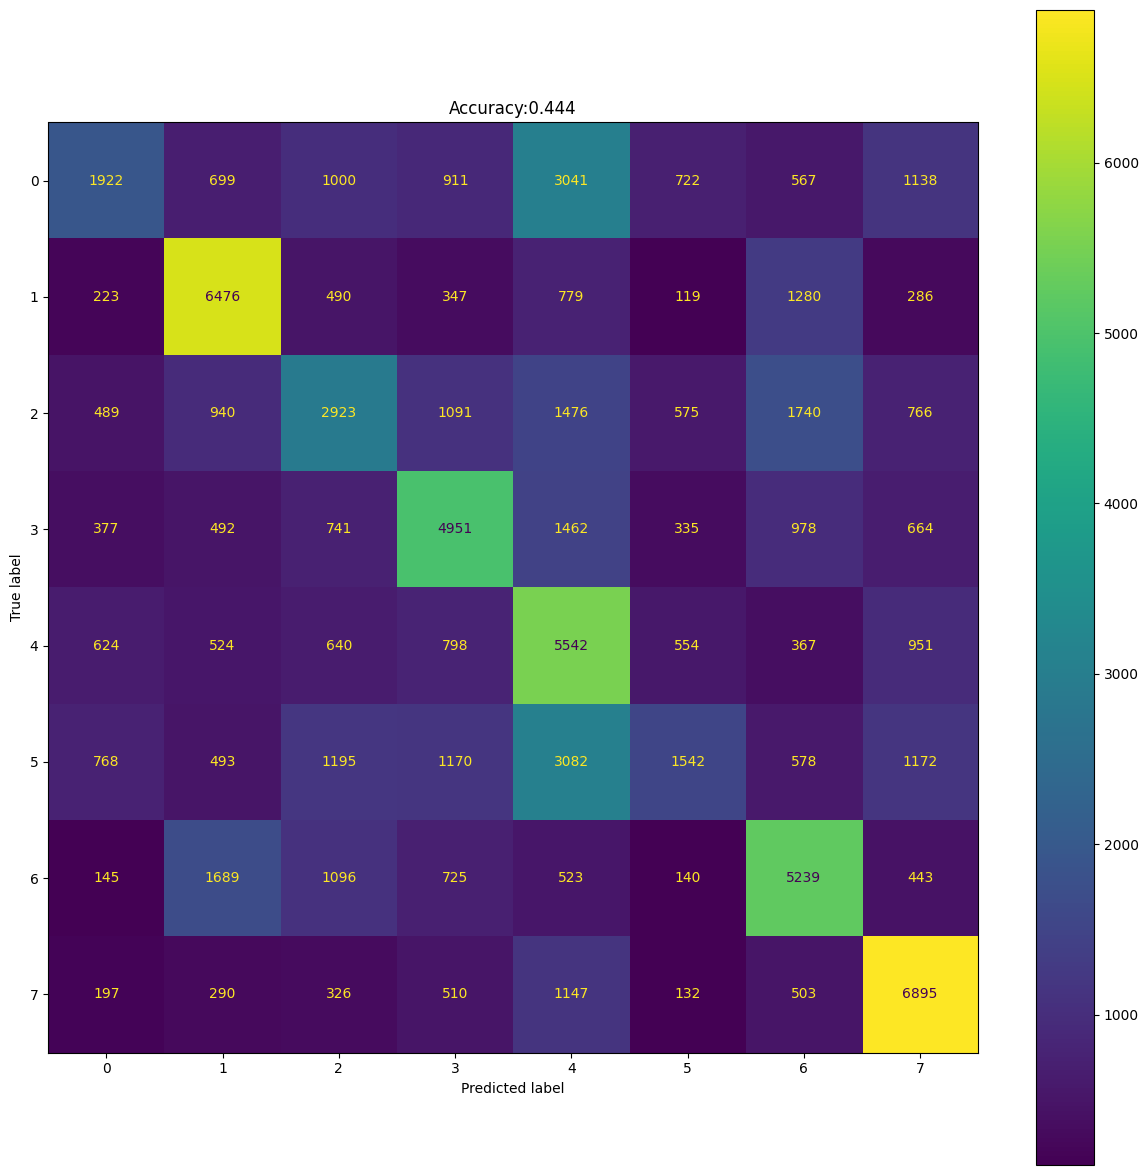

In [59]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(iii) dataset 

In [60]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [61]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 8.5896 - accuracy: 0.1356
test loss, test acc: [8.589569091796875, 0.13561250269412994]


In [62]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 1 6 ... 2 2 5]
5
[[  12    3 1652    2    0 7798  526    7]
 [   0   20 1271   15    0 8305  387    2]
 [   8    3 2901    2    0 6450  629    7]
 [  18    0 2440    0    0 7037  500    5]
 [  27    0 2860    1    0 6444  668    0]
 [  13    2 2107    3    0 7223  651    1]
 [   2   14 2530   10    0 6727  684   33]
 [   8    3 3105    1    0 5963  911    9]]
              precision    recall  f1-score   support

           0       0.14      0.00      0.00     10000
           1       0.44      0.00      0.00     10000
           2       0.15      0.29      0.20     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.72      0.22     10000
           6       0.14      0.07      0.09     10000
           7       0.14      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.14      0.14  

Test Accuracy:0.1356125


Text(0.5, 1.0, 'Accuracy:0.136')

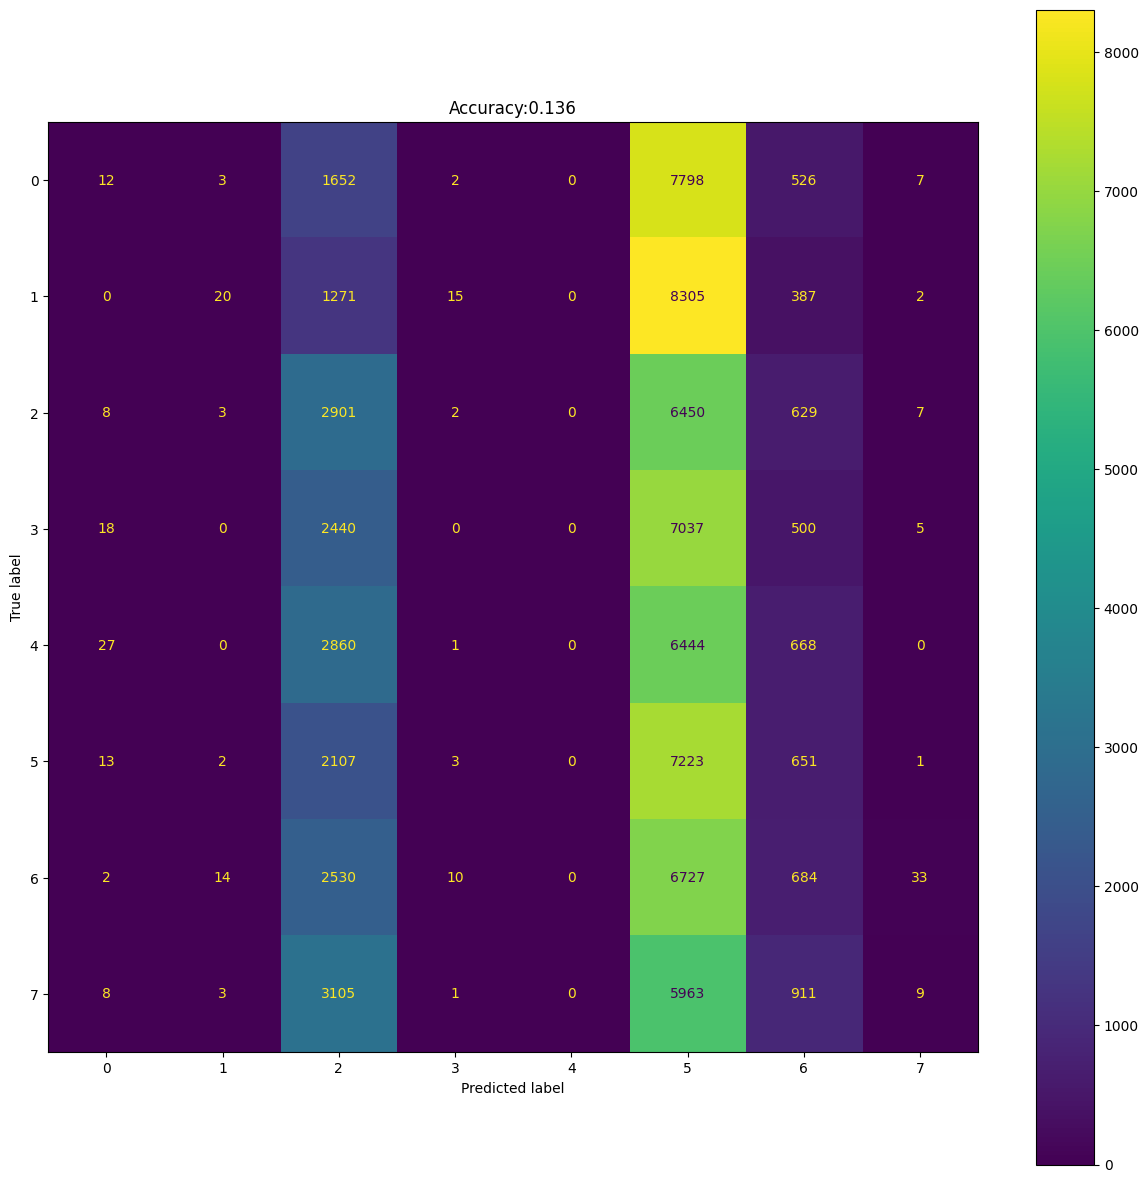

In [63]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [64]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [65]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [66]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.8983 - accuracy: 0.1630
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.0947 - accuracy: 0.2092
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.9377 - accuracy: 0.2550
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8716 - accuracy: 0.2839
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8332 - accuracy: 0.3060
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8047 - accuracy: 0.3224
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.7824 - accuracy: 0.3388
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7628 - accuracy: 0.3530
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7466 - accuracy: 0.3631
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

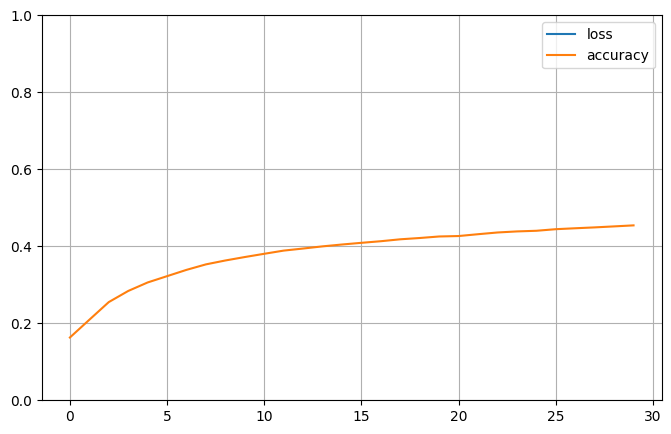

In [67]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [68]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.5618 - accuracy: 0.4569
test loss, test acc: [1.561827301979065, 0.45688751339912415]


In [69]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 6 6 ... 4 6 6]
6
[[3597  714 1663 1199  654  405 1237  531]
 [ 354 7671 1056   19  108  169  584   39]
 [ 837  764 4896  874  602  276 1355  396]
 [ 902  115 1162 6025  404  190  740  462]
 [1541  681 2755 1211 2008  464  870  470]
 [1971 1018 2534  886  979  986  985  641]
 [1174  915 1995  832  295  146 4156  487]
 [ 510  394  636  456  200  181  411 7212]]
              precision    recall  f1-score   support

           0       0.33      0.36      0.34     10000
           1       0.63      0.77      0.69     10000
           2       0.29      0.49      0.37     10000
           3       0.52      0.60      0.56     10000
           4       0.38      0.20      0.26     10000
           5       0.35      0.10      0.15     10000
           6       0.40      0.42      0.41     10000
           7       0.70      0.72      0.71     10000

    accuracy                           0.46     80000
   macro avg       0.45      0.46  

Test Accuracy:0.4568875


Text(0.5, 1.0, 'Accuracy:0.457')

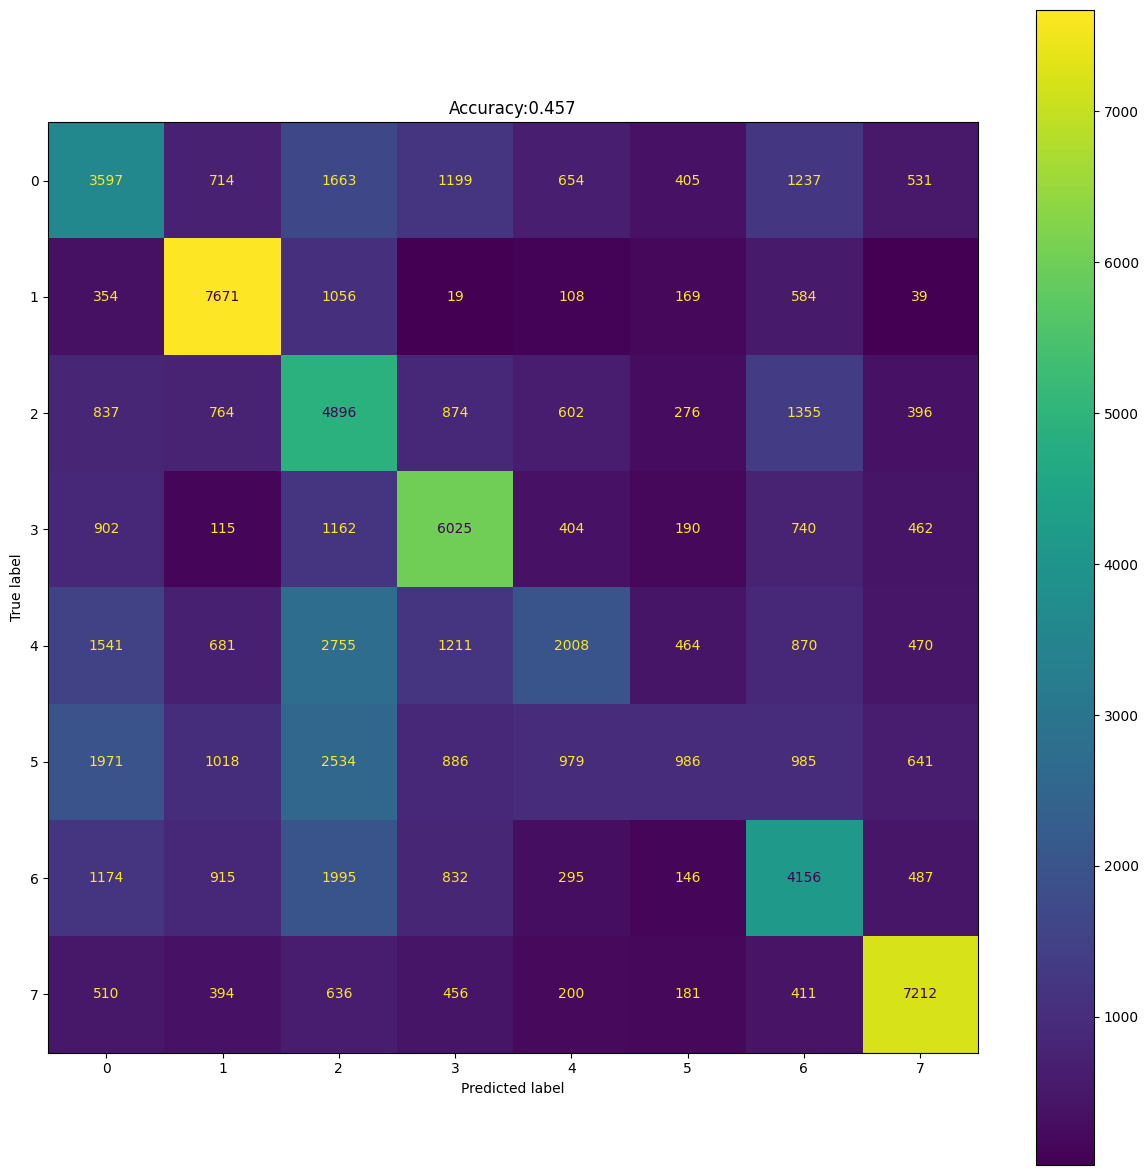

In [70]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(iii) dataset 

In [71]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [72]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 4.9287 - accuracy: 0.1128
test loss, test acc: [4.928679943084717, 0.11277499794960022]


In [73]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 3 4 ... 5 4 2]
3
[[  19    3 2857  299  876 5490  130  326]
 [   1  132 2196   43  499 6834  285   10]
 [   7   19 2447  409 1649 5006  238  225]
 [   6   29 4075  104 1590 3930   68  198]
 [   8   13 2756  117  745 5991  169  201]
 [  21    7 3025  231 1102 5189  139  286]
 [   7   18 4651  194 1695 2877  309  249]
 [  22   75 2433  154 3333 3585  321   77]]
              precision    recall  f1-score   support

           0       0.21      0.00      0.00     10000
           1       0.45      0.01      0.03     10000
           2       0.10      0.24      0.14     10000
           3       0.07      0.01      0.02     10000
           4       0.06      0.07      0.07     10000
           5       0.13      0.52      0.21     10000
           6       0.19      0.03      0.05     10000
           7       0.05      0.01      0.01     10000

    accuracy                           0.11     80000
   macro avg       0.16      0.11  

Test Accuracy:0.112775


Text(0.5, 1.0, 'Accuracy:0.113')

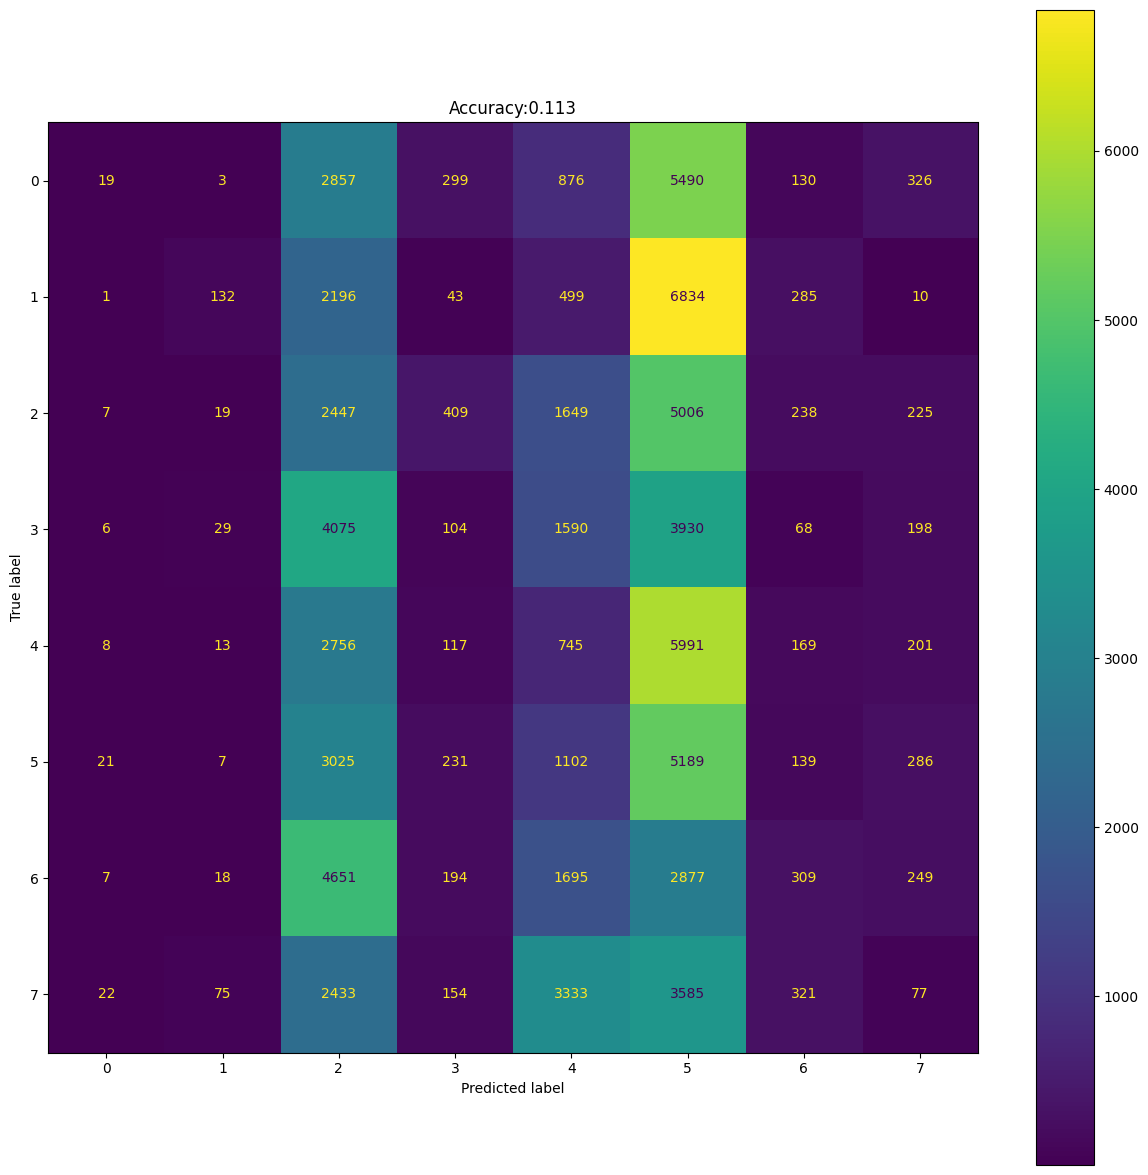

In [74]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [75]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [76]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [77]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9749 - accuracy: 0.1569
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.1279 - accuracy: 0.2202
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8973 - accuracy: 0.2802
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8308 - accuracy: 0.3082
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8012 - accuracy: 0.3238
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7832 - accuracy: 0.3312
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7691 - accuracy: 0.3371
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7577 - accuracy: 0.3423
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7471 - accuracy: 0.3494
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

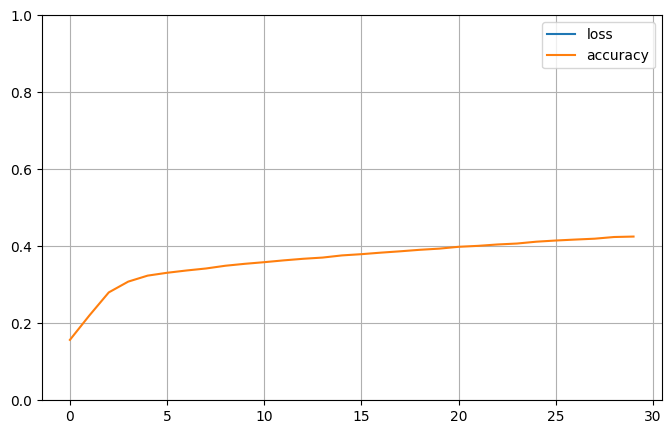

In [78]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [79]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.6054 - accuracy: 0.4290
test loss, test acc: [1.6053712368011475, 0.42903751134872437]


In [80]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 2 6 ... 4 7 0]
2
[[3808  662  966  965 1850  123 1032  594]
 [ 324 7363  427  368  476   81  439  522]
 [1265 1126 2959 1099 1065  263 1398  825]
 [ 956  801  676 4823  792  120 1042  790]
 [1704  971  766  701 3898  155 1021  784]
 [2107  830 1298 1257 1864  553 1084 1007]
 [ 940  707  973 1125  885  105 4413  852]
 [ 427  691  347  498  847  150  534 6506]]
              precision    recall  f1-score   support

           0       0.33      0.38      0.35     10000
           1       0.56      0.74      0.64     10000
           2       0.35      0.30      0.32     10000
           3       0.45      0.48      0.46     10000
           4       0.33      0.39      0.36     10000
           5       0.36      0.06      0.10     10000
           6       0.40      0.44      0.42     10000
           7       0.55      0.65      0.59     10000

    accuracy                           0.43     80000
   macro avg       0.42      0.43  

Test Accuracy:0.4290375


Text(0.5, 1.0, 'Accuracy:0.429')

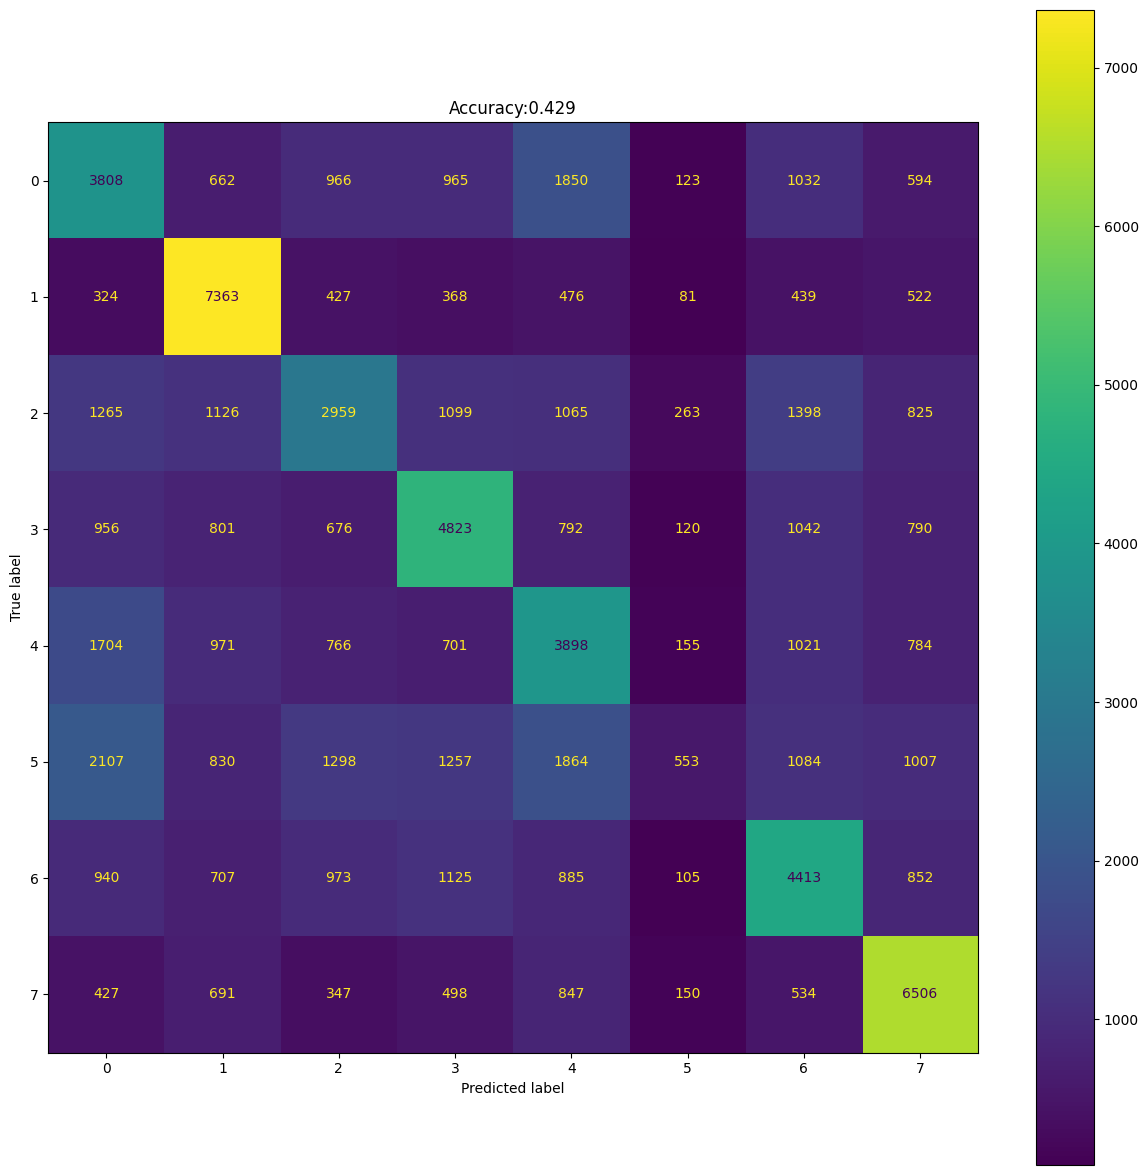

In [81]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-25(iii) dataset 

In [82]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [83]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 7.0558 - accuracy: 0.1206
test loss, test acc: [7.055849075317383, 0.12056250125169754]


In [84]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 4 4 ... 5 5 5]
4
[[1444    0  885   58    6 7593   14    0]
 [2170    0 1259    5    6 6557    3    0]
 [1003    0  361   13    0 8612   11    0]
 [ 181    0  182    0    0 9611   25    1]
 [2933    0  823   18    0 6224    2    0]
 [1664    0  512   16    0 7799    9    0]
 [ 538    0  300    3    0 9118   41    0]
 [2741    0 1220   26    0 5989   24    0]]
              precision    recall  f1-score   support

           0       0.11      0.14      0.13     10000
           1       0.00      0.00      0.00     10000
           2       0.07      0.04      0.05     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.78      0.22     10000
           6       0.32      0.00      0.01     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.08      0.12  

Test Accuracy:0.1205625


Text(0.5, 1.0, 'Accuracy:0.121')

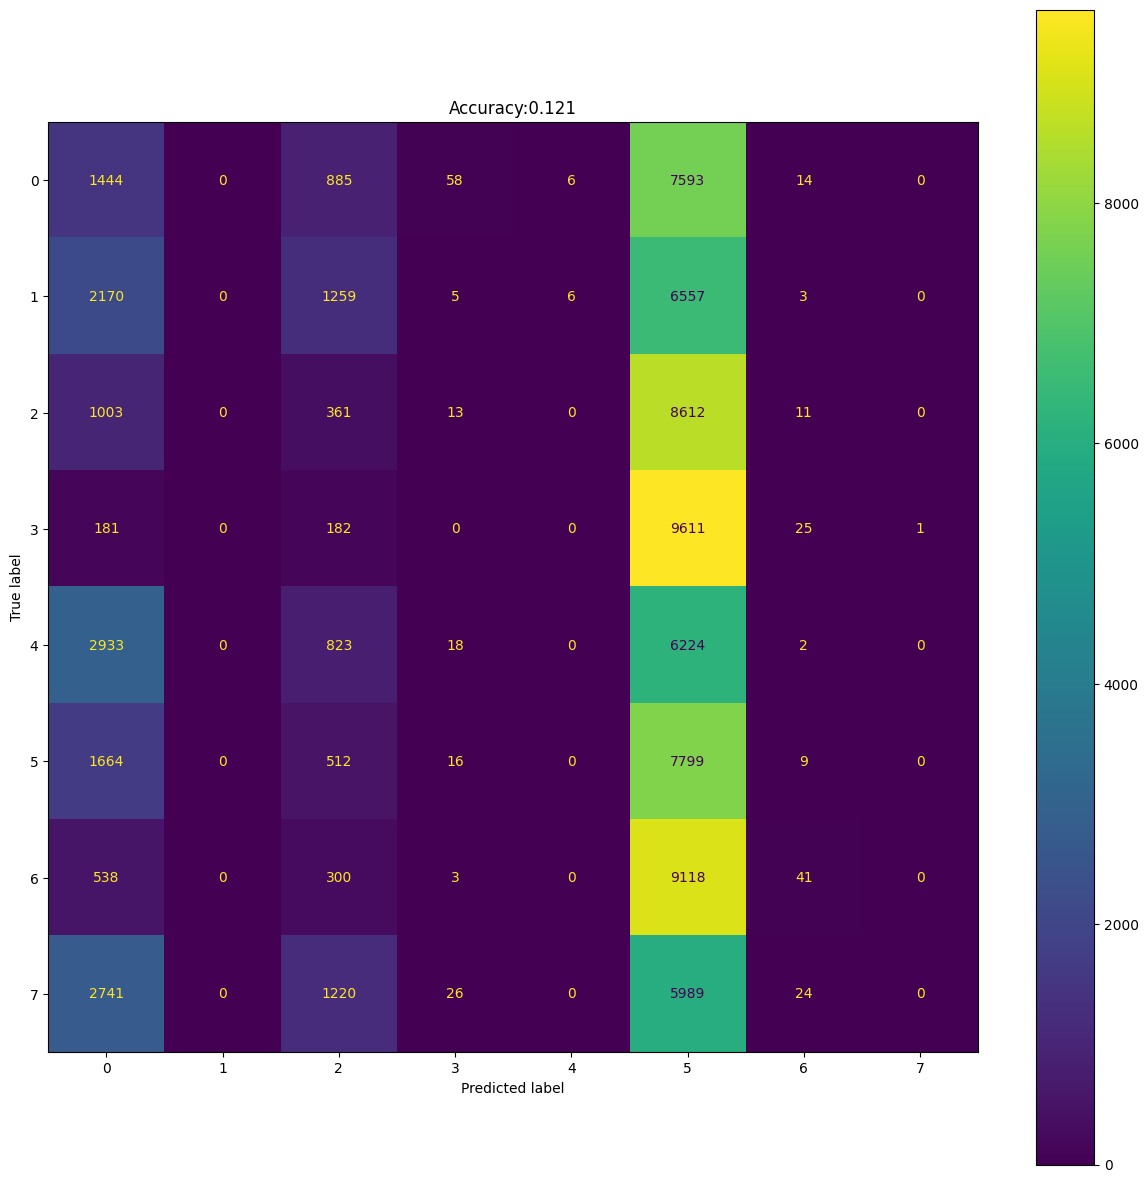

In [85]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [86]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [87]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [88]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9530 - accuracy: 0.1420
Epoch 2/30
2500/2500 [==============================] - 8s 3ms/step - loss: 2.0565 - accuracy: 0.2129
Epoch 3/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.9096 - accuracy: 0.2544
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8543 - accuracy: 0.2804
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8203 - accuracy: 0.2996
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7941 - accuracy: 0.3144
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7723 - accuracy: 0.3267
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7532 - accuracy: 0.3357
Epoch 9/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.7361 - accuracy: 0.3454
Epoch 10/30
2500/2500 [==============================] - 11s 5ms/step - loss: 

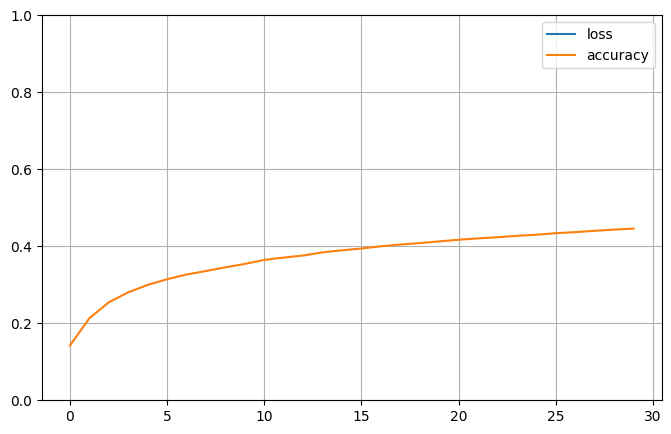

In [89]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [90]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.5497 - accuracy: 0.4480
test loss, test acc: [1.5496883392333984, 0.4480375051498413]


In [91]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 1 6 ... 2 6 2]
1
[[3446  503  781  725 1503 1650  824  568]
 [ 219 7855  376  279  254  177  550  290]
 [1074  885 2700 1124  746 1508 1481  482]
 [ 590  550  843 5488  261  708 1384  176]
 [1521  457  627  424 4312 1832  401  426]
 [1420  661 1136  699 1346 3041 1104  593]
 [ 631  704 1012 1449  289  901 4611  403]
 [ 891 1220  631  357  604  969  938 4390]]
              precision    recall  f1-score   support

           0       0.35      0.34      0.35     10000
           1       0.61      0.79      0.69     10000
           2       0.33      0.27      0.30     10000
           3       0.52      0.55      0.53     10000
           4       0.46      0.43      0.45     10000
           5       0.28      0.30      0.29     10000
           6       0.41      0.46      0.43     10000
           7       0.60      0.44      0.51     10000

    accuracy                           0.45     80000
   macro avg       0.45      0.45  

Test Accuracy:0.4480375


Text(0.5, 1.0, 'Accuracy:0.448')

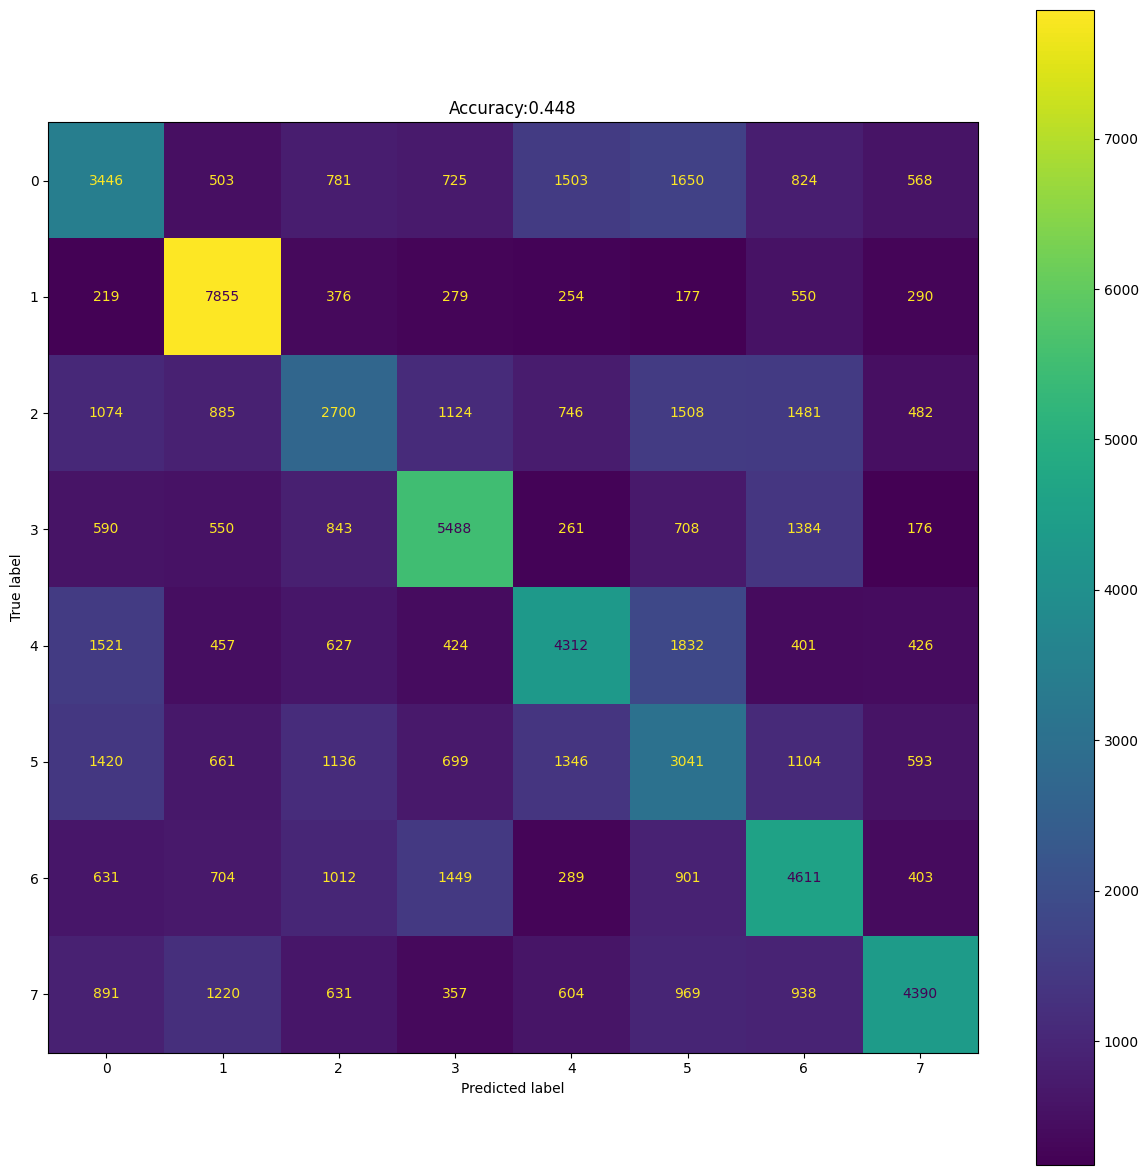

In [92]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-25(iii) dataset 

In [93]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [94]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.9727 - accuracy: 0.1395
test loss, test acc: [5.972710609436035, 0.1395374983549118]


In [95]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[4 4 4 ... 0 0 0]
4
[[4506    1  354  126    6 5004    2    1]
 [5726    7  127    5    6 4037   91    1]
 [5528    1  360   99    0 3991   21    0]
 [2823    2  277   22    0 6866    8    2]
 [3303    0  187   53    0 6447    1    9]
 [3516    3  227   49    0 6192    9    4]
 [5878    0  573   28    0 3450   71    0]
 [6212    1  484   45    0 3227   26    5]]
              precision    recall  f1-score   support

           0       0.12      0.45      0.19     10000
           1       0.47      0.00      0.00     10000
           2       0.14      0.04      0.06     10000
           3       0.05      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.16      0.62      0.25     10000
           6       0.31      0.01      0.01     10000
           7       0.23      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.18      0.14  

Test Accuracy:0.1395375


Text(0.5, 1.0, 'Accuracy:0.140')

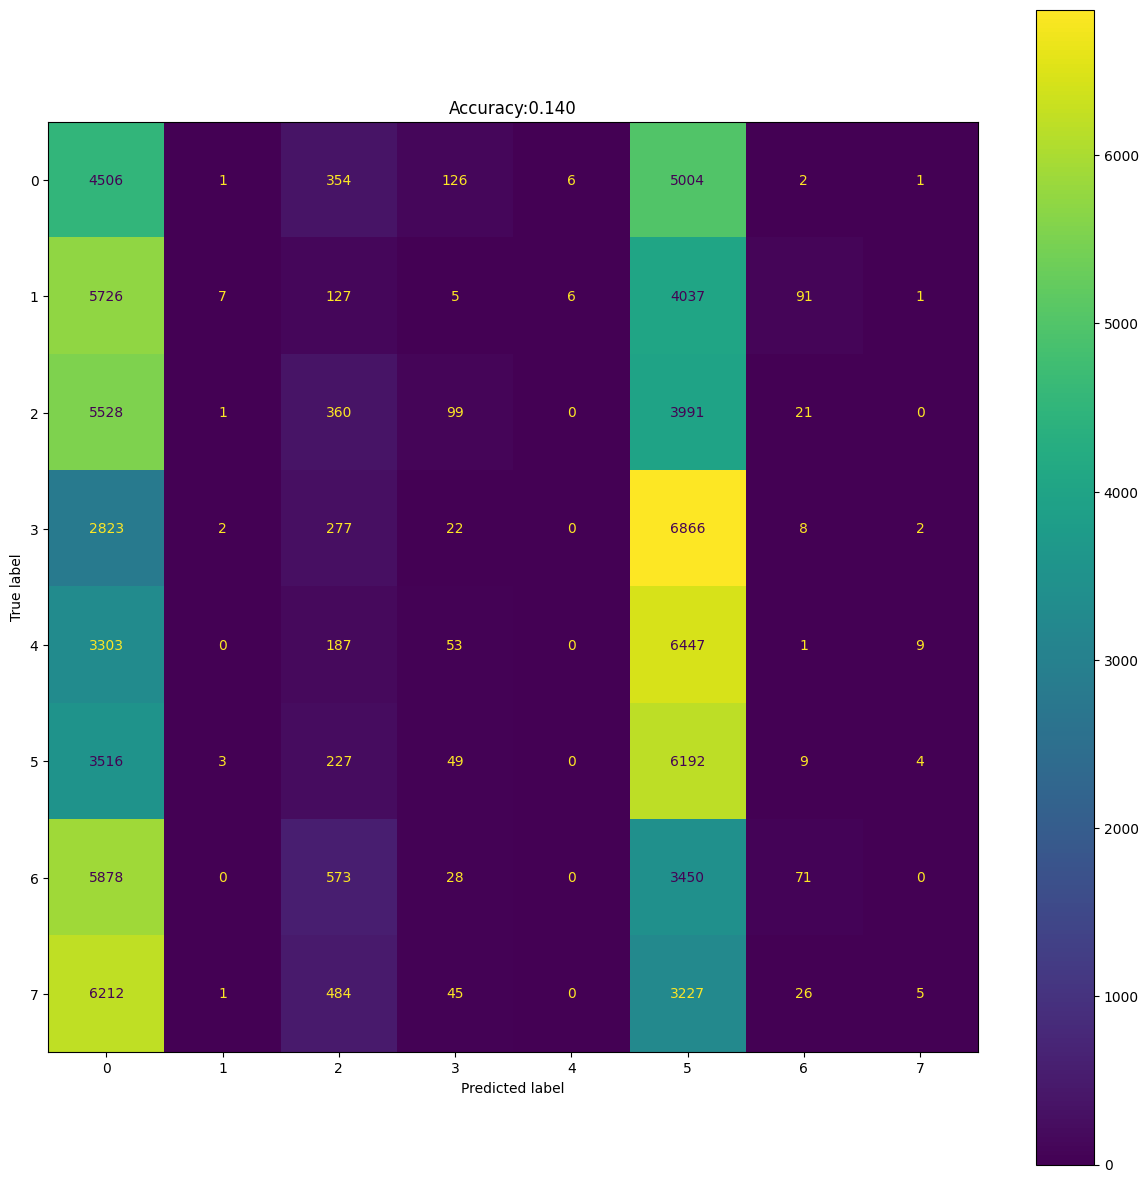

In [96]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [97]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [98]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [99]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8294 - accuracy: 0.1529
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.1880 - accuracy: 0.1970
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9757 - accuracy: 0.2406
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8882 - accuracy: 0.2729
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8433 - accuracy: 0.2935
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8153 - accuracy: 0.3100
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7952 - accuracy: 0.3214
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7792 - accuracy: 0.3307
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7651 - accuracy: 0.3389
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

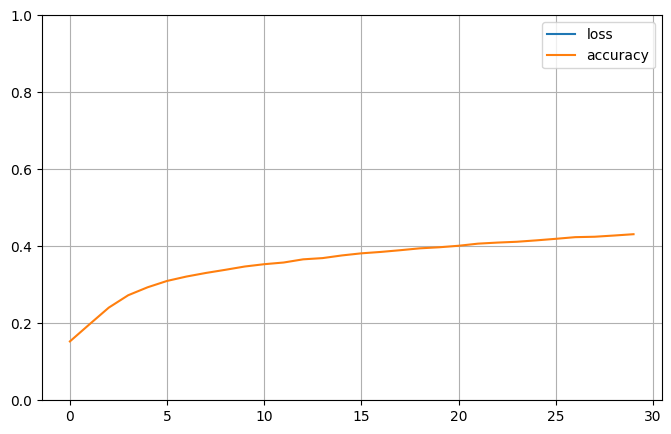

In [100]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [101]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.5932 - accuracy: 0.4329
test loss, test acc: [1.593170166015625, 0.43287500739097595]


In [102]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 7 7 ... 6 1 0]
7
[[4361  604  538  640 1413  952  732  760]
 [ 199 7196  320  451  198  339  751  546]
 [1880 1258 2011  922  574  785 1152 1418]
 [ 669 1029  385 5128  709  453  856  771]
 [2397  451  239  842 3562 1402  662  445]
 [2092  947  510 1034 1622 2198  942  655]
 [ 617 1914  568 1075  517  478 3307 1524]
 [ 527  595  309  828  304  172  398 6867]]
              precision    recall  f1-score   support

           0       0.34      0.44      0.38     10000
           1       0.51      0.72      0.60     10000
           2       0.41      0.20      0.27     10000
           3       0.47      0.51      0.49     10000
           4       0.40      0.36      0.38     10000
           5       0.32      0.22      0.26     10000
           6       0.38      0.33      0.35     10000
           7       0.53      0.69      0.60     10000

    accuracy                           0.43     80000
   macro avg       0.42      0.43  

Test Accuracy:0.432875


Text(0.5, 1.0, 'Accuracy:0.433')

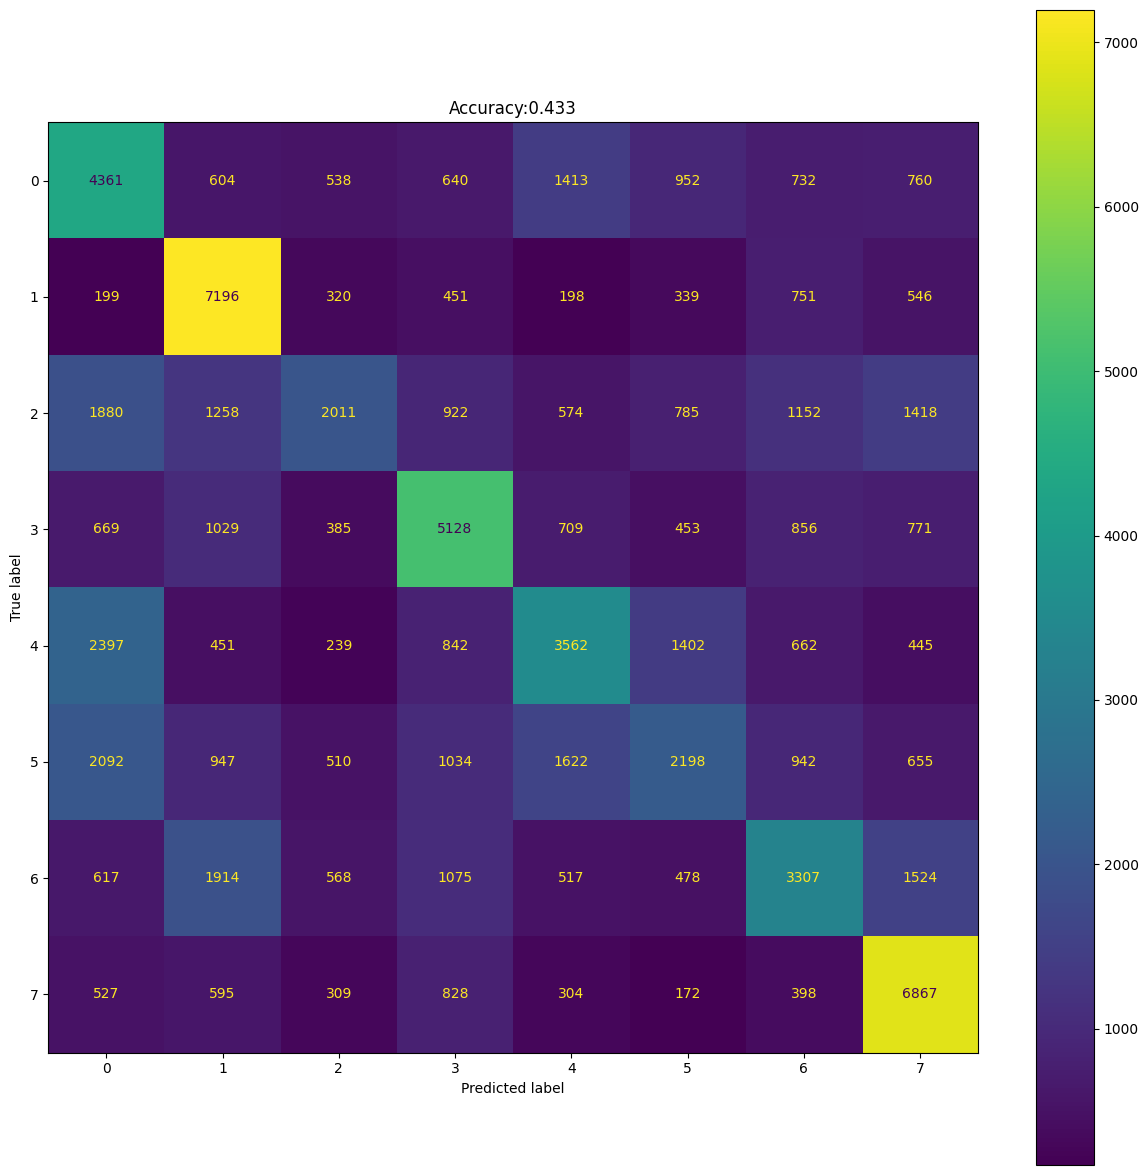

In [103]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')